# Thoracic Surgery Life Expectancy Classification

In [2]:
%%capture
!pip install seaborn
!pip install xgboost
!pip install dexplot

In [3]:
# loading dataset
from scipy.io import arff
import urllib.request
from io import StringIO
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import dexplot as dxp

# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# parameter tuning
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, classification_report

rs = 1

## Loading the Dataset

In [5]:

# download dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00277/ThoraricSurgery.arff"
ftpstream = urllib.request.urlopen(url)
data, meta = arff.loadarff(StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data)

# strip vaues according to utf-8 encoding 
df = df.select_dtypes([np.object])
df = df.stack().str.decode('utf-8').unstack()

In [6]:
df.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


## Preprocessing

### Check that there are no missing values.

In [7]:
desc = df.describe() # saving it to use it during visualisation
desc

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,7,3,2,2,2,2,2,4,2,2,2,2,2,2
top,DGN3,PRZ1,F,F,F,T,F,OC12,F,F,F,T,F,F
freq,349,313,439,402,439,323,392,257,435,468,462,386,468,400


In [8]:
df.notnull().describe()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,True,True,True,True
freq,470,470,470,470,470,470,470,470,470,470,470,470,470,470


### Visualise data

In [9]:
df_surv = df.loc[df["Risk1Yr"] == 'F']
df_died = df.loc[df["Risk1Yr"] == 'T']

features = dict(DGN =   'Diagnosis',
        #PRE4 =	'Forced vital capacity',
        #PRE5 =	'Volume that has been exhaled at the end of the first second of forced expiration',
        PRE6 =	'Performance status - Zubrod scale',
        PRE7 =	'Pain before surgery',
        PRE8 =  'Haemoptysis before surgery',
        PRE9 =	'Dyspnoea before surgery',
        PRE10 =	'Cough before surgery',
        PRE11 = 'Weakness before surgery',
        PRE14 = 'size of the original tumour',
        PRE17 = 'Type 2 DM - diabetes mellitus',
        PRE19 = 'MI up to 6 months',
        PRE25 = 'PAD - peripheral arterial diseases',
        PRE30 = 'Smoking',
        PRE32 = 'Asthma',
        #AGE =   'Age at surgery'
        )

In [10]:
df_surv.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
5,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,F,F,F


fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
plt.style.use('seaborn-deep')

for k,v in features.items():
    c += 1
    val = list(desc[k])[1] # possible values for each column
    chart = fig.add_subplot(5,5,c)
    chart.title.set_text(v)
    
    bins = np.linspace(0, val, num=val+1)

    surv = df_surv[k]
    died = df_died[k]

    chart.hist(surv , bins, alpha=1, color='pink', label='survived', rwidth=6)
    chart.hist(died , bins, alpha=0.1, color='blue', label='died', rwidth=6)

    plt.legend(loc='upper right')

plt.show()

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


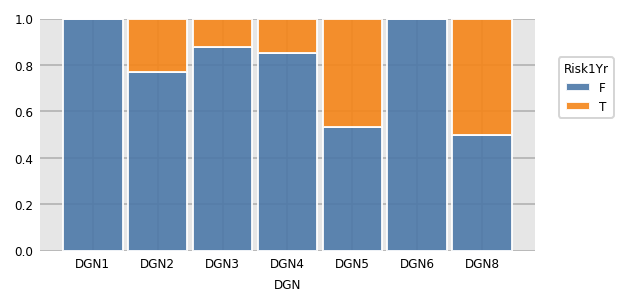

In [11]:
feat = list(df.columns)[0] # change index number to observe fatality of other features
dxp.count(val=feat, data=df, split='Risk1Yr',
          normalize=[feat], stacked=True)
# yellow = died    blue = survived

In [12]:
df.shape

(470, 14)

In [13]:
target = df.Risk1Yr
target.shape

(470,)

In [14]:
labels = np.reshape(target.values,(470,1))
labels.shape

(470, 1)

In [16]:
feature_ds = np.concatenate([df, labels], axis=1)
feature_ds.shape

(470, 15)

In [34]:
ds = pd.DataFrame(feature_ds)
ds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,T


In [19]:
ds.columns = ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'Risk1Yr', 'label']
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,T


In [20]:
ds['label'].replace('F', 'Survived',inplace=True)
ds['label'].replace('T', 'Died',inplace=True)
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,Died


,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,Died


In [21]:
ohe = OneHotEncoder()
ds_e = pd.DataFrame(ohe.fit_transform(ds.to_numpy()).toarray())
ds_e.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [25]:
sum(ds.describe().iloc[1,]) == len(ds_e.columns) # to check the possible feature values correspond to the number of columns

True

### Shuffle and split data into features X and target y.

In [35]:
ds_er = ds_e.sample(frac=1)

X = ds_er.iloc[:,:-4]
y = ds_er.iloc[:,-1]

## Algorithm

In [36]:
# splitting train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### Define the baselines

In [37]:
%%capture
models = [LogisticRegression(random_state=rs),
          MultinomialNB(),
          KNeighborsClassifier(),
          SVC(random_state=rs),
          LinearSVC(random_state=rs),
          DecisionTreeClassifier(random_state=rs),
          RandomForestClassifier(random_state=rs),
          GradientBoostingClassifier(random_state=rs),
          XGBClassifier(random_state=rs)]

model = []
mean = []
std = []
mins = []
maxs = []

for m in models:
    cross = cross_val_score(m, X_train, y_train, cv=5)
    model.append(type(m).__name__)
    mean.append(cross.mean())
    std.append(cross.std())
    mins.append(min(cross))
    maxs.append(max(cross))

In [42]:
result = pd.DataFrame({"Model":model, "acc_mean":mean, "STD":std, "min":mins, "max":maxs})
result.sort_values("acc_mean", ascending=False)

,Model,acc_mean,STD,min,max
3,SVC,0.851096,0.005221,0.848485,0.861538
2,KNeighborsClassifier,0.848112,0.018581,0.818182,0.876923
6,RandomForestClassifier,0.832867,0.013054,0.818182,0.848485
7,GradientBoostingClassifier,0.826946,0.048985,0.742424,0.892308
4,LinearSVC,0.826853,0.019814,0.803030,0.861538
0,LogisticRegression,0.820793,0.037138,0.757576,0.861538
1,MultinomialNB,0.820746,0.033378,0.757576,0.848485
5,DecisionTreeClassifier,0.805501,0.030703,0.757576,0.848485
8,XGBClassifier,0.805455,0.035152,0.757576,0.863636


### Improve parameters of the best performing model

In [44]:
loss = ['hinge', 'squared_hinge']
penalty = ['l1', 'l2', 'elasticnet']
dual = [True, False]
tol = list(np.arange(0.0001,0.001,0.0001))
C = np.logspace(-4, 4, 20)

pipe = Pipeline([('classifier', SVC())])



In [46]:
param_grid = [
   {'classifier' : [LinearSVC(max_iter=10000, random_state=rs)],
     'classifier__penalty' : penalty,
     'classifier__dual' : dual,
     'classifier__tol' : tol,
     'classifier__C' : C,
     'classifier__loss' : loss}]

In [47]:
clf = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5)
best_clf = clf.fit(X_train, y_train)

In [48]:
best_clf.best_estimator_['classifier']

LinearSVC(C=0.0001, loss='hinge', max_iter=10000, random_state=1)

In [49]:
best_clf.best_score_

0.8510955710955711

## Test Results

In [53]:
# predicting over test set
y_pred = best_clf.predict(X_test)

[Text(0.5, 20.0, 'predicted'), Text(38.0, 0.5, 'actual')]

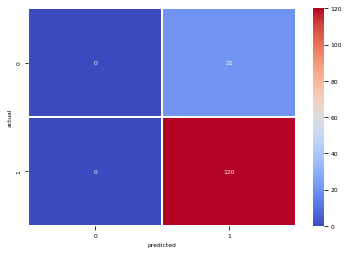

In [54]:
# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='coolwarm')
matrix.set(xlabel='predicted', ylabel='actual')

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.85      1.00      0.92       120

    accuracy                           0.85       141
   macro avg       0.43      0.50      0.46       141
weighted avg       0.72      0.85      0.78       141

